In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
np.random.seed(100)

In [2]:
class perceptron:
    # Lista con los pesos para las entradas del perceptron
    w=[]
    # Salida del perceptron
    y=0
    delta=0
    # Funcion de activacion: 1 = funcion sigmoide; 2 = funcion tangente hiperbolica
    f_activ=1
    # Tasa de aprendizaje
    n = 1.5
    
    # Inicializa pesos aleatorios segun la cantidad de entradas que recibira el perceptron
    # por lo general, n_entradas = entradas + bias
    def __init__(self, n_entradas):
        self.w=np.random.rand(n_entradas)

    # Funcion de activacion/transferencia
    def factivacion(self, x):
        if(self.f_activ==1):
            # funcion sigmoide
            return 1/(1+math.exp(-x))
        elif(self.f_activ==2):
            # funcion tangente hiperbolica
            return ( 2/(1+math.exp(-2*x)) ) -1
        
    def dfactivacion(self, x):
        if(self.f_activ==1):
            # funcion sigmoide
            return x*(1-x)
        elif(self.f_activ==2):
            # funcion tangente hiperbolica
            return 1-(x*x)

    def predict(self, x):
        suma=0
        for i in range(len(x)):
            suma += x[i]*self.w[i]
            
        self.y = self.factivacion(suma)
    
    def train(self, x):
        for i in range( len(self.w) ):
            self.w[i] += self.n*self.delta*self.dfactivacion(self.y)*x[i]
    


In [3]:
class rn_multicapa:
    # Lista que almacena las capas ocultas del perceptron
    hiddenLayers = []
    # Lista que almacena los perceptrones de la capa de salida
    # Las salidas de la RN se encuentran en outputLayer[n].y
    outputLayer = []
    # Valor del sesgo
    vSesgo=1
    
    # inicializa una red neuronal una capa de entrada, una capa oculta y una de salida
    def __init__(self, size_inputLayer, size_hiddenLayer, size_outputLayer):
        self.hiddenLayers.clear()
        self.outputLayer.clear()
        self.hiddenLayers.append([])
        # Crea size_inputLayer perceptrones en la lista de la capa de entrada
        # Inicializa cada perceptron para tener size_input pesos, mas un peso para el bias
        for p in range(size_hiddenLayer):
            self.hiddenLayers[0].append(perceptron(size_inputLayer+1)) 
            
        # Crea size_outputLayer perceptrones en la lista de la capa de salida
        # Inicializa cada perceptron para tener size_inputLayer pesos, mas un peso para el bias
        for r in range(size_outputLayer):
            self.outputLayer.append(perceptron(size_hiddenLayer+1))

    # Crea una nueva capa oculta con size_hiddenlayer perceptrones, y la agrega a la lista de capas ocultas
    def addHiddenLayer(self, size_hiddenLayer):
        newLayer = []
        for p in range(size_hiddenLayer):
            # Agrega los perceptrones, con cantidad de entradas igual a las salidas de la capa oculta anterior
            newLayer.append( perceptron( len(self.hiddenLayers[-1]) ) )
        # Agregar la nueva capa a la lista
        self.hiddenLayers.append(newLayer)
        
        #Conecta la nueva capa a la capa de salida
        t=len(self.outputLayer)
        self.outputLayer.clear()
        for p in range(t):
            self.outputLayer.append(perceptron(size_hiddenLayer+1))
        
        
    def predict(self, x):
        # Agrega temporalmente la entrada bias al conjunto de entrada
        x.append(self.vSesgo) 
        # Almacena temporalmente las salidas de los perceptrones de una capa para pasarlas a la siguiente
        data = []
        # data[0] = capa de entradas
        # data[1:] = salidas de cada capa oculta
        data.append(x.copy())
        # Recorre las capas ocultas para obtener sus salidas
        for layer in range( len(self.hiddenLayers) ):
            # Agregar un elemento vacio a la lista, donde se almacenara las salidas de la capa actual
            data.append([])
            # Recorre los perceptrones de la capa
            for p in self.hiddenLayers[layer]:
                p.predict(data[layer])
                # Almacena los sets de salidas de cada capa a partir del indice 1 de la lista data
                data[layer+1].append(p.y)
        # Con el ultimo elemento de la lista data como entrada
        # calcula el output de los perceptrones en la capa de salida
        # Agrega una entrada bias a la ultima capa oculta
        data[-1].append(self.vSesgo)
        for p in self.outputLayer:
            p.predict(data[-1])
            
        data.clear()
        x.pop() 
        
    # Recibe un conjunto de entradas x y su conjunto de salidas correctas z
    def train(self, x, z):
        self.predict(x)        
        ## Calculo de deltas
        # Definimos los deltas de los perceptrones en la capa de salida
        for p in range( len(self.outputLayer) ):
            self.outputLayer[p].delta = z[p]-self.outputLayer[p].y

        # Definimos los deltas de los perceptrones en las capas ocultas
        # Retropropagacion: Comenzamos a calcular los deltas de cada nodo comenzando desde la ultima capa oculta
        allLayers = []
        for l in self.hiddenLayers:
            allLayers.append(l)
        allLayers.append(self.outputLayer)
        
        # Recorre las capas ocultas
        for layer in reversed( range( len(allLayers)-1 ) ):
            # Recorre los perceptrones de cada capa
            for p in range( len(allLayers[layer]) ):
                suma = 0
                for np in allLayers[layer+1]:
                    suma += np.delta*np.w[p]
                allLayers[layer][p].delta = suma
        
        ## Calculo de nuevos pesos
        x.append(self.vSesgo)
        temp=[[]]
        # entrenar primera capa
        for p in self.hiddenLayers[0]:
            p.train(x)
            temp[0].append(p.y)
        x.pop()
        # entrenar capas intermedias
        for idx,layer in enumerate(self.hiddenLayers[1:]):
            temp.append([])
            for p in layer:
                p.train(temp[idx])
                temp[idx+1].append(p.y)
        # entrenar capa de salida
        temp[-1].append(self.vSesgo)
        for p in self.outputLayer:
            p.train(temp[-1])
        
        temp.clear()
        allLayers.clear()
        self.predict(x)
        

    def printWeights(self):
        print("--- Perceptrones de las capas ocultas ---")
        for idx,layer in enumerate(self.hiddenLayers):
            print(f"<< Capa oculta {idx+1} >>")
            for p in range( len(layer) ):
                print(f"\tPerceptron {p+1}:")
                for w in range(len(layer[p].w)):
                    print(f"\t\tw{w+1} = {layer[p].w[w]}")
        
        print("--- Perceptrones de la capa de salida ---")
        for p in range( len(self.outputLayer) ):
            print(f"\tPerceptron {p+1}:")
            for w in range(len(self.outputLayer[p].w)):
                print(f"\t\tw{w+1} = {self.outputLayer[p].w[w]}")
            

In [4]:
# Inicializa una red neuronal que recibe 3 inputs,
# tiene 6 perceptrones de entrada y 1 de salida
rn=rn_multicapa(3,4,2)
#rn.addHiddenLayer(3)
#rn.addHiddenLayer(2)
print("Pesos iniciales")
# rn.printWeights()

Pesos iniciales


In [5]:
setX = [[1,1,1],
        [1,1,0],
        [1,0,1],
        [1,0,0],
        [0,1,1],
        [0,1,0],
        [0,0,1],
        [0,0,0]]

# Set para un perceptron de salida
#setZ = [[1],[0],[0],[1],[0],[1],[1],[0]]
# Set para dos perceptrones de salida
setZ = [[1,0],[0,1],[0,1],[1,0],[0,1],[1,0],[1,0],[0,1]]

In [6]:
def toVF(x):
    if(x>0.5):
        return 1
    else:
        return 0

In [7]:
print("Valores deseados:")
for i, s in enumerate(setX):
    print( s[0], s[1], s[2], "|", setZ[i] )

print("Valores predichos:")
print("x1 x2 | x1 XOR x2")
for s in setX:
    rn.predict(s)
    print( s[0], s[1], s[2], "|", toVF(rn.outputLayer[0].y), f" => Y = {rn.outputLayer[0].y}" )

Valores deseados:
1 1 1 | [1, 0]
1 1 0 | [0, 1]
1 0 1 | [0, 1]
1 0 0 | [1, 0]
0 1 1 | [0, 1]
0 1 0 | [1, 0]
0 0 1 | [1, 0]
0 0 0 | [0, 1]
Valores predichos:
x1 x2 | x1 XOR x2
1 1 1 | 1  => Y = 0.9023085573494752
1 1 0 | 1  => Y = 0.8845639971738948
1 0 1 | 1  => Y = 0.8930126711609273
1 0 0 | 1  => Y = 0.8685168136466389
0 1 1 | 1  => Y = 0.8954537457748433
0 1 0 | 1  => Y = 0.8736317168364701
0 0 1 | 1  => Y = 0.8837900119555444
0 0 0 | 1  => Y = 0.8543190997715651


In [8]:
outputs_1 = {"[1,1,1]": [],
          "[1,1,0]": [],
          "[1,0,1]": [],
          "[1,0,0]": [],
          "[0,1,1]": [],
          "[0,1,0]": [],
          "[0,0,1]": [],
          "[0,0,0]": []}
outputs_2 = {"[1,1,1]": [],
          "[1,1,0]": [],
          "[1,0,1]": [],
          "[1,0,0]": [],
          "[0,1,1]": [],
          "[0,1,0]": [],
          "[0,0,1]": [],
          "[0,0,0]": []}
out_df_1 = pd.DataFrame(outputs_1)
out_df_2 = pd.DataFrame(outputs_2)

In [9]:
# Bucle de épocas de entrenamiento.
for j in range(2000):
    yvalues1 = []
    yvalues2 = []
    for i in range(len(setX)):
        rn.predict(setX[i])
        yvalues1.append(rn.outputLayer[0].y)
        yvalues2.append(rn.outputLayer[1].y)
    out_df_1.loc[len(out_df_1.index)] = yvalues1
    out_df_2.loc[len(out_df_2.index)] = yvalues2
    
    for i in range(len(setX)):
        rn.train(setX[i], setZ[i])
        rn.predict(setX[i])

In [10]:
print("Valores predichos:")
print("x1 x2 | x1 XOR x2")
for s in setX:
    rn.predict(s)
    print( s[0], s[1], s[2], "|", toVF(rn.outputLayer[0].y))#, toVF(rn.outputLayer[1].y), f" => Y1 = {rn.outputLayer[0].y}, Y2 = {rn.outputLayer[1].y}" )

Valores predichos:
x1 x2 | x1 XOR x2
1 1 1 | 1
1 1 0 | 1
1 0 1 | 0
1 0 0 | 1
0 1 1 | 0
0 1 0 | 1
0 0 1 | 1
0 0 0 | 0


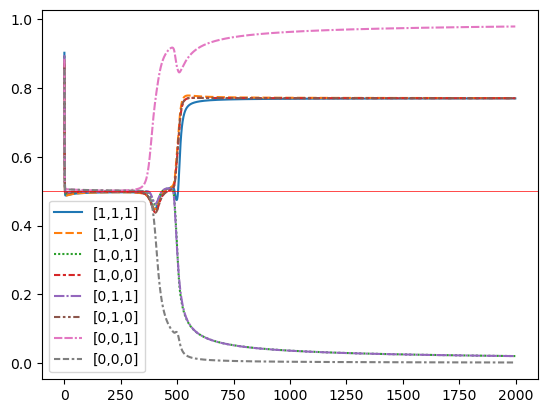

In [11]:
graph1 = sns.lineplot(out_df_1)
graph1.axhline(y=.5, linewidth=0.5, color='r') 

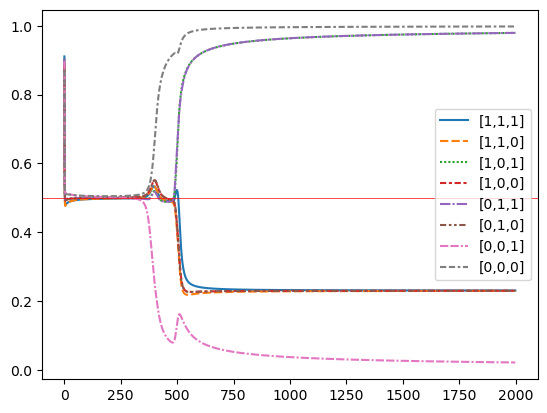

In [12]:
graph2 = sns.lineplot(out_df_2)
graph2.axhline(y=.5, linewidth=0.5, color='r') 